In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, RepeatedKFold
from scipy import sparse
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
from datetime import datetime

In [4]:
#导入数据
train_abbr=pd.read_csv("raw_data/happiness_train_abbr.csv",encoding='ISO-8859-1')
train=pd.read_csv("raw_data/happiness_train_complete.csv",encoding='ISO-8859-1')
test_abbr=pd.read_csv("raw_data/happiness_test_abbr.csv",encoding='ISO-8859-1')
test=pd.read_csv("raw_data/happiness_test_complete.csv",encoding='ISO-8859-1')
test_sub=pd.read_csv("raw_data/happiness_submit.csv",encoding='ISO-8859-1')

In [5]:
#观察数据大小
test.shape

(2968, 139)

In [6]:
test_sub.shape

(2968, 2)

In [7]:
train.shape

(8000, 140)

In [8]:
#简单查看数据
train.head()

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,religion_freq,edu,edu_other,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,property_other,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,invest_other,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
0,1,4,1,12,32,59,2015/8/4 14:18,1,1959,1,1,1,11,NaN,4.0,-2.0,20000,1,NaN,45.0,0,1,0,0,0,0,0,0,0,NaN,176,155,3,2,5,5,2.0,4,2,5,5,4,3,1,4,3,1,2,3,4,1,4,5,4,1,2,4,3,3.0,3.0,2,3,3,3,3,1,1,3.0,30.0,1.0,2.0,1,1,1,2,60000.0,2,2,1,2,0,1,0,0,0,0,0,0,0,NaN,1,0,0.0,3,1984.0,1958.0,1984.0,6.0,1.0,5.0,40000.0,5.0,NaN,NaN,-2,4,4,1,-2,4,1,1,3,2,4,3,50000.0,4,2,-8,-8,5,3,2,3,4,3,-8,4,1,4,50,60,50,50,30.0,30,50,50,50
1,2,4,2,18,52,85,2015/7/21 15:04,1,1992,1,1,1,12,NaN,4.0,2013.0,20000,1,NaN,110.0,0,0,0,0,1,0,0,0,0,NaN,170,110,5,4,3,1,1.0,2,2,1,3,5,1,2,3,4,3,5,4,3,2,3,4,5,1,2,4,3,6.0,2.0,1,3,6,4,8,5,1,3.0,2.0,1.0,3.0,1,1,1,1,40000.0,3,4,1,2,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1972,3,1,2,1973,3,1,2,1,1,4,2,50000.0,5,4,4,3,5,3,3,3,2,3,3,3,2,3,90,70,70,80,85.0,70,90,60,60
2,3,4,2,29,83,126,2015/7/21 13:24,2,1967,1,0,3,4,NaN,4.0,-2.0,2000,1,NaN,120.0,0,1,1,0,0,0,0,0,0,NaN,160,122,4,4,5,1,1.0,2,2,2,5,1,3,1,4,4,3,5,4,4,2,3,5,5,5,3,4,2,2.0,5.0,2,4,5,4,6,3,2,NaN,NaN,NaN,NaN,1,1,2,2,8000.0,3,3,1,2,0,1,0,0,0,0,0,0,0,NaN,0,2,1.0,3,1990.0,1968.0,1990.0,3.0,1.0,1.0,6000.0,3.0,NaN,NaN,-2,1,1,2,-2,1,1,2,2,1,4,2,80000.0,3,3,3,3,4,3,3,3,3,3,-8,3,1,4,90,80,75,79,80.0,90,90,90,75
3,4,5,2,10,28,51,2015/7/25 17:33,2,1943,1,1,1,3,NaN,4.0,1959.0,6420,1,NaN,78.0,0,0,0,1,0,0,0,0,0,NaN,163,170,4,4,4,1,2.0,2,1,1,5,1,1,1,5,2,4,5,4,5,1,1,5,5,5,2,4,4,1.0,6.0,1,4,5,5,7,2,4,NaN,NaN,NaN,NaN,2,2,2,2,12000.0,3,3,1,1,0,1,0,0,0,0,0,0,0,NaN,1,4,0.0,7,1960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2,14,1,2,-2,1,1,2,2,1,3,2,10000.0,3,3,4,3,5,3,3,5,4,3,3,3,2,3,100,90,70,80,80.0,90,90,80,80
4,5,4,1,7,18,36,2015/8/10 9:50,2,1994,1,1,1,12,NaN,1.0,2014.0,-1,2,NaN,70.0,0,0,0,0,1,0,0,0,0,NaN,165,110,5,5,3,2,3.0,1,3,4,2,5,5,3,3,3,2,4,4,3,5,2,5,5,1,4,3,4,7.0,5.0,3,2,1,1,1,4,6,NaN,NaN,NaN,NaN,1,2,2,2,-2.0,4,3,1,1,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970,6,1,10,1972,4,1,15,3,2,3,-8,200000.0,4,3,3,3,5,5,3,4,3,3,3,3,2,2,50,50,50,50,50.0,50,50,50,50


In [9]:
#查看数据是否缺失
train.info(verbose=True)
print("\nNull values count:\n", train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 140 columns):
 #    Column                Dtype  
---   ------                -----  
 0    id                    int64  
 1    happiness             int64  
 2    survey_type           int64  
 3    province              int64  
 4    city                  int64  
 5    county                int64  
 6    survey_time           object 
 7    gender                int64  
 8    birth                 int64  
 9    nationality           int64  
 10   religion              int64  
 11   religion_freq         int64  
 12   edu                   int64  
 13   edu_other             object 
 14   edu_status            float64
 15   edu_yr                float64
 16   income                int64  
 17   political             int64  
 18   join_party            float64
 19   floor_area            float64
 20   property_0            int64  
 21   property_1            int64  
 22   property_2            

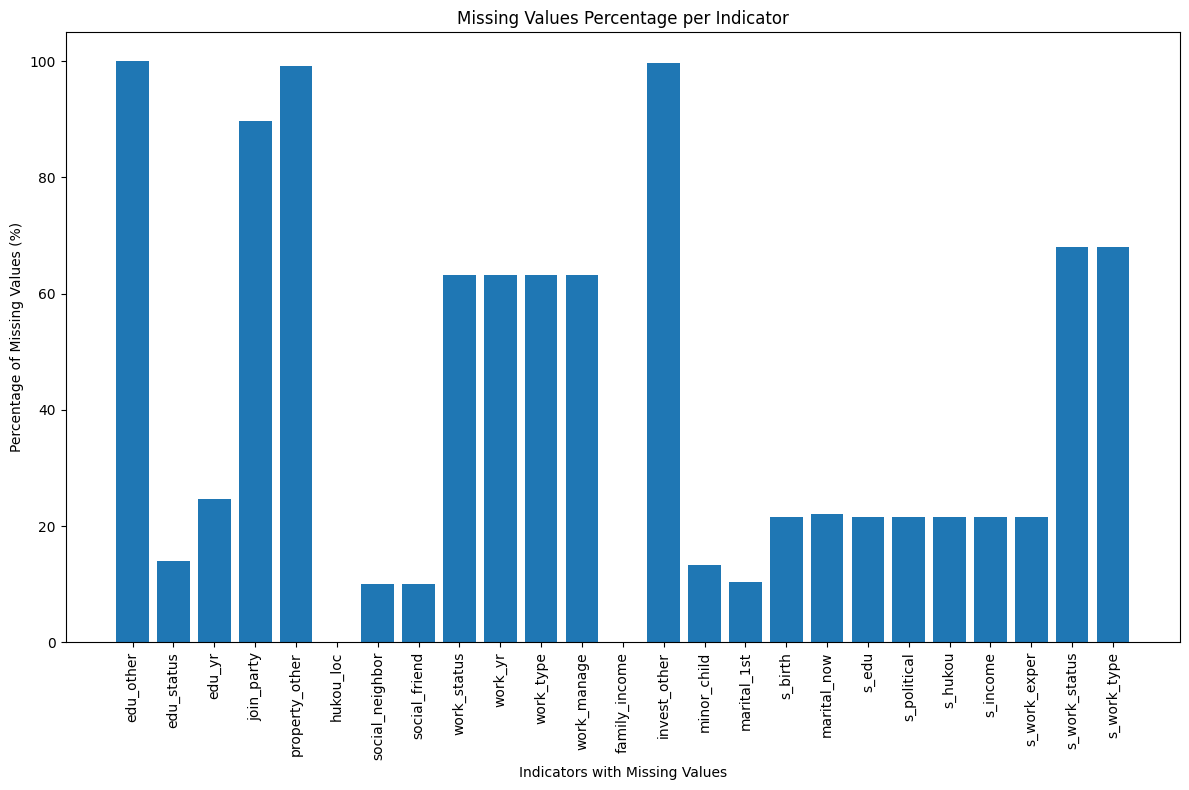

In [10]:
import matplotlib.pyplot as plt

# Calculate the percentage of missing values for each column in the DataFrame
missing_percentage = train.isnull().mean() * 100
missing_percentage = missing_percentage[missing_percentage > 0]  # Filter out columns with no missing values

# Plot the missing value percentages
plt.figure(figsize=(12, 8))
plt.bar(missing_percentage.index, missing_percentage.values)
plt.xlabel("Indicators with Missing Values")
plt.ylabel("Percentage of Missing Values (%)")
plt.title("Missing Values Percentage per Indicator")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [11]:
#查看label分布
y_train_=train["happiness"]
y_train_.value_counts()

happiness
 4    4818
 5    1410
 3    1159
 2     497
 1     104
-8      12
Name: count, dtype: int64

In [12]:
#将-8换成3
y_train_=y_train_.map(lambda x:3 if x==-8 else x)


In [13]:
y_train_.head()

0    4
1    4
2    4
3    5
4    4
Name: happiness, dtype: int64

In [14]:
#让label从0开始
y_train_=y_train_.map(lambda x:x-1)

In [15]:
y_train_.head()

0    3
1    3
2    3
3    4
4    3
Name: happiness, dtype: int64

In [16]:
#train和test连在一起
data = pd.concat([train,test],axis=0,ignore_index=True)

In [17]:
#全部数据大小
data.shape

(10968, 140)

In [18]:
#处理时间特征
data['survey_time'] = pd.to_datetime(data['survey_time'],format='%Y/%m/%d %H:%M')
data["weekday"]=data["survey_time"].dt.weekday
data["year"]=data["survey_time"].dt.year
data["quarter"]=data["survey_time"].dt.quarter
data["hour"]=data["survey_time"].dt.hour
data["month"]=data["survey_time"].dt.month

In [19]:
#把一天的时间分段
def hour_cut(x):
    if 0<=x<6:
        return 0
    elif  6<=x<8:
        return 1
    elif  8<=x<12:
        return 2
    elif  12<=x<14:
        return 3
    elif  14<=x<18:
        return 4
    elif  18<=x<21:
        return 5
    elif  21<=x<24:
        return 6

    
data["hour_cut"]=data["hour"].map(hour_cut)

In [20]:
#做问卷时候的年龄
data["survey_age"]=data["year"]-data["birth"]

In [21]:
#去掉三个缺失值很多的
# edu_other 去掉
# join_party null->0 
# property_other null->0
# invest_other null->0
# s_work_status null->0
# s_work_type null->0
# work_status null->0
# work_yr null->0
# work_type null->0
# work_manage null->0
data=data.drop(["edu_other"], axis=1)
data=data.drop(["happiness"], axis=1)
data=data.drop(["survey_time"], axis=1)

In [22]:
#是否入党
data["join_party"]=data["join_party"].map(lambda x:0 if pd.isnull(x)  else 1)

In [23]:
#出生的年代
def birth_split(x):
    if 1920<=x<=1930:
        return 0
    elif  1930<x<=1940:
        return 1
    elif  1940<x<=1950:
        return 2
    elif  1950<x<=1960:
        return 3
    elif  1960<x<=1970:
        return 4
    elif  1970<x<=1980:
        return 5
    elif  1980<x<=1990:
        return 6
    elif  1990<x<=2000:
        return 7
    
data["birth_s"]=data["birth"].map(birth_split)
   

In [24]:
#收入分组
def income_cut(x):
    if x<0:
        return 0
    elif  0<=x<1200:
        return 1
    elif  1200<x<=10000:
        return 2
    elif  10000<x<24000:
        return 3
    elif  24000<x<40000:
        return 4
    elif  40000<=x:
        return 5
 

    
data["income_cut"]=data["income"].map(income_cut)

In [25]:
#填充数据
data["edu_status"]=data["edu_status"].fillna(5)
data["edu_yr"]=data["edu_yr"].fillna(-2)
data["property_other"]=data["property_other"].map(lambda x:0 if pd.isnull(x)  else 1)
data["hukou_loc"]=data["hukou_loc"].fillna(1)
data["social_neighbor"]=data["social_neighbor"].fillna(8)
data["social_friend"]=data["social_friend"].fillna(8)
data["work_status"]=data["work_status"].fillna(0)
data["work_yr"]=data["work_yr"].fillna(0)
data["work_type"]=data["work_type"].fillna(0)
data["work_manage"]=data["work_manage"].fillna(0)
data["family_income"]=data["family_income"].fillna(-2)
data["invest_other"]=data["invest_other"].map(lambda x:0 if pd.isnull(x)  else 1)

In [26]:
#填充数据
data["minor_child"]=data["minor_child"].fillna(0)
data["marital_1st"]=data["marital_1st"].fillna(0)
data["s_birth"]=data["s_birth"].fillna(0)
data["marital_now"]=data["marital_now"].fillna(0)
data["s_edu"]=data["s_edu"].fillna(0)
data["s_political"]=data["s_political"].fillna(0)
data["s_hukou"]=data["s_hukou"].fillna(0)
data["s_income"]=data["s_income"].fillna(0)
data["s_work_exper"]=data["s_work_exper"].fillna(0)
data["s_work_status"]=data["s_work_status"].fillna(0)
data["s_work_type"]=data["s_work_type"].fillna(0)

In [27]:
data=data.drop(["id"], axis=1)

In [28]:
X_train_ = data[:train.shape[0]]
X_test_  = data[train.shape[0]:]

In [ ]:
data.head()

In [30]:
target_column = 'happiness'
feature_columns=list(X_test_.columns) 
feature_columns

['survey_type',
 'province',
 'city',
 'county',
 'gender',
 'birth',
 'nationality',
 'religion',
 'religion_freq',
 'edu',
 'edu_status',
 'edu_yr',
 'income',
 'political',
 'join_party',
 'floor_area',
 'property_0',
 'property_1',
 'property_2',
 'property_3',
 'property_4',
 'property_5',
 'property_6',
 'property_7',
 'property_8',
 'property_other',
 'height_cm',
 'weight_jin',
 'health',
 'health_problem',
 'depression',
 'hukou',
 'hukou_loc',
 'media_1',
 'media_2',
 'media_3',
 'media_4',
 'media_5',
 'media_6',
 'leisure_1',
 'leisure_2',
 'leisure_3',
 'leisure_4',
 'leisure_5',
 'leisure_6',
 'leisure_7',
 'leisure_8',
 'leisure_9',
 'leisure_10',
 'leisure_11',
 'leisure_12',
 'socialize',
 'relax',
 'learn',
 'social_neighbor',
 'social_friend',
 'socia_outing',
 'equity',
 'class',
 'class_10_before',
 'class_10_after',
 'class_14',
 'work_exper',
 'work_status',
 'work_yr',
 'work_type',
 'work_manage',
 'insur_1',
 'insur_2',
 'insur_3',
 'insur_4',
 'family_income'

In [31]:
X_train = np.array(X_train_)
y_train = np.array(y_train_)
X_test  = np.array(X_test_)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
X_test.shape

In [32]:
#自定义评价函数
def myFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_squared_error(label,preds)
    return 'myFeval',score

In [33]:
##### xgb

xgb_params = {"booster":'gbtree','eta': 0.005, 'max_depth': 5, 'subsample': 0.7, 
              'colsample_bytree': 0.8, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 8}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])
    
    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params,feval = myFeval)
    # oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.num_boost_rounds)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]))
    # predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.num_boost_rounds) / folds.n_splits
    predictions_xgb += clf.predict(xgb.DMatrix(X_test)) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, y_train_)))

fold n°1
[0]	train-rmse:0.82384	train-myFeval:0.67872	valid_data-rmse:0.79246	valid_data-myFeval:0.62799


/Users/akai/anaconda3/envs/happiness_prediction/lib/python3.11/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/Users/akai/anaconda3/envs/happiness_prediction/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:10:20] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/akai/anaconda3/envs/happiness_prediction/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:10:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	train-rmse:0.74531	train-myFeval:0.55549	valid_data-rmse:0.73540	valid_data-myFeval:0.54081
[200]	train-rmse:0.69835	train-myFeval:0.48770	valid_data-rmse:0.70726	valid_data-myFeval:0.50022
[300]	train-rmse:0.66729	train-myFeval:0.44527	valid_data-rmse:0.69219	valid_data-myFeval:0.47913
[400]	train-rmse:0.64463	train-myFeval:0.41555	valid_data-rmse:0.68310	valid_data-myFeval:0.46662
[500]	train-rmse:0.62679	train-myFeval:0.39286	valid_data-rmse:0.67799	valid_data-myFeval:0.45966
[600]	train-rmse:0.61168	train-myFeval:0.37415	valid_data-rmse:0.67413	valid_data-myFeval:0.45445
[700]	train-rmse:0.59850	train-myFeval:0.35820	valid_data-rmse:0.67144	valid_data-myFeval:0.45083
[800]	train-rmse:0.58715	train-myFeval:0.34475	valid_data-rmse:0.66969	valid_data-myFeval:0.44848
[900]	train-rmse:0.57631	train-myFeval:0.33213	valid_data-rmse:0.66816	valid_data-myFeval:0.44644
[1000]	train-rmse:0.56641	train-myFeval:0.32082	valid_data-rmse:0.66692	valid_data-myFeval:0.44479
[1100]	train-rmse:0

/Users/akai/anaconda3/envs/happiness_prediction/lib/python3.11/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/Users/akai/anaconda3/envs/happiness_prediction/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:10:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/akai/anaconda3/envs/happiness_prediction/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:10:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	train-rmse:0.73889	train-myFeval:0.54595	valid_data-rmse:0.76806	valid_data-myFeval:0.58991
[200]	train-rmse:0.69319	train-myFeval:0.48051	valid_data-rmse:0.73259	valid_data-myFeval:0.53668
[300]	train-rmse:0.66272	train-myFeval:0.43920	valid_data-rmse:0.71408	valid_data-myFeval:0.50992
[400]	train-rmse:0.64026	train-myFeval:0.40993	valid_data-rmse:0.70313	valid_data-myFeval:0.49439
[500]	train-rmse:0.62232	train-myFeval:0.38728	valid_data-rmse:0.69635	valid_data-myFeval:0.48490
[600]	train-rmse:0.60733	train-myFeval:0.36885	valid_data-rmse:0.69174	valid_data-myFeval:0.47850
[700]	train-rmse:0.59443	train-myFeval:0.35335	valid_data-rmse:0.68867	valid_data-myFeval:0.47426
[800]	train-rmse:0.58314	train-myFeval:0.34005	valid_data-rmse:0.68635	valid_data-myFeval:0.47107
[900]	train-rmse:0.57292	train-myFeval:0.32823	valid_data-rmse:0.68468	valid_data-myFeval:0.46878
[1000]	train-rmse:0.56386	train-myFeval:0.31794	valid_data-rmse:0.68343	valid_data-myFeval:0.46708
[1100]	train-rmse:0

/Users/akai/anaconda3/envs/happiness_prediction/lib/python3.11/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/Users/akai/anaconda3/envs/happiness_prediction/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:10:38] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/akai/anaconda3/envs/happiness_prediction/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:10:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	train-rmse:0.73859	train-myFeval:0.54551	valid_data-rmse:0.76460	valid_data-myFeval:0.58461
[200]	train-rmse:0.69223	train-myFeval:0.47918	valid_data-rmse:0.73236	valid_data-myFeval:0.53636
[300]	train-rmse:0.66109	train-myFeval:0.43704	valid_data-rmse:0.71549	valid_data-myFeval:0.51192
[400]	train-rmse:0.63853	train-myFeval:0.40772	valid_data-rmse:0.70531	valid_data-myFeval:0.49746
[500]	train-rmse:0.62022	train-myFeval:0.38467	valid_data-rmse:0.69866	valid_data-myFeval:0.48812
[600]	train-rmse:0.60552	train-myFeval:0.36665	valid_data-rmse:0.69450	valid_data-myFeval:0.48233
[700]	train-rmse:0.59292	train-myFeval:0.35155	valid_data-rmse:0.69173	valid_data-myFeval:0.47849
[800]	train-rmse:0.58180	train-myFeval:0.33849	valid_data-rmse:0.68952	valid_data-myFeval:0.47544
[900]	train-rmse:0.57171	train-myFeval:0.32685	valid_data-rmse:0.68779	valid_data-myFeval:0.47305
[1000]	train-rmse:0.56242	train-myFeval:0.31632	valid_data-rmse:0.68651	valid_data-myFeval:0.47129
[1100]	train-rmse:0

/Users/akai/anaconda3/envs/happiness_prediction/lib/python3.11/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/Users/akai/anaconda3/envs/happiness_prediction/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:10:48] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/akai/anaconda3/envs/happiness_prediction/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:10:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	train-rmse:0.73960	train-myFeval:0.54702	valid_data-rmse:0.76640	valid_data-myFeval:0.58737
[200]	train-rmse:0.69447	train-myFeval:0.48228	valid_data-rmse:0.73057	valid_data-myFeval:0.53373
[300]	train-rmse:0.66438	train-myFeval:0.44141	valid_data-rmse:0.71160	valid_data-myFeval:0.50638
[400]	train-rmse:0.64181	train-myFeval:0.41192	valid_data-rmse:0.69938	valid_data-myFeval:0.48913
[500]	train-rmse:0.62370	train-myFeval:0.38900	valid_data-rmse:0.69171	valid_data-myFeval:0.47846
[600]	train-rmse:0.60848	train-myFeval:0.37025	valid_data-rmse:0.68635	valid_data-myFeval:0.47107
[700]	train-rmse:0.59562	train-myFeval:0.35477	valid_data-rmse:0.68259	valid_data-myFeval:0.46592
[800]	train-rmse:0.58437	train-myFeval:0.34149	valid_data-rmse:0.68033	valid_data-myFeval:0.46285
[900]	train-rmse:0.57408	train-myFeval:0.32957	valid_data-rmse:0.67840	valid_data-myFeval:0.46022
[1000]	train-rmse:0.56466	train-myFeval:0.31884	valid_data-rmse:0.67719	valid_data-myFeval:0.45859
[1100]	train-rmse:0

/Users/akai/anaconda3/envs/happiness_prediction/lib/python3.11/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/Users/akai/anaconda3/envs/happiness_prediction/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:10:55] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/akai/anaconda3/envs/happiness_prediction/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:10:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	train-rmse:0.74157	train-myFeval:0.54993	valid_data-rmse:0.74960	valid_data-myFeval:0.56190
[200]	train-rmse:0.69381	train-myFeval:0.48138	valid_data-rmse:0.72165	valid_data-myFeval:0.52078
[300]	train-rmse:0.66229	train-myFeval:0.43863	valid_data-rmse:0.70789	valid_data-myFeval:0.50111
[400]	train-rmse:0.63941	train-myFeval:0.40884	valid_data-rmse:0.69960	valid_data-myFeval:0.48944
[500]	train-rmse:0.62137	train-myFeval:0.38610	valid_data-rmse:0.69444	valid_data-myFeval:0.48224
[600]	train-rmse:0.60622	train-myFeval:0.36751	valid_data-rmse:0.69106	valid_data-myFeval:0.47757
[700]	train-rmse:0.59304	train-myFeval:0.35169	valid_data-rmse:0.68886	valid_data-myFeval:0.47453
[800]	train-rmse:0.58130	train-myFeval:0.33791	valid_data-rmse:0.68708	valid_data-myFeval:0.47208
[900]	train-rmse:0.57083	train-myFeval:0.32584	valid_data-rmse:0.68558	valid_data-myFeval:0.47002
[1000]	train-rmse:0.56119	train-myFeval:0.31494	valid_data-rmse:0.68433	valid_data-myFeval:0.46831
[1100]	train-rmse:0